In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as si

In [2]:
data = si.loadmat('data/wiki_db.mat')

In [3]:
train_set = data['image'].reshape(38138,-1)/255

In [21]:
def one_hot_enc(vec, vals=10):
    out = np.zeros((vals,))
    for i in range(len(vec)):
        l = np.zeros((vals,))
        index = int(vec[i]/10)
        if index!=10:
            l[index] = 1
        else:
            l[9] = 1
        out = np.vstack((out,l))
    out = np.delete(out,0,0)
    return out

In [22]:
labels = one_hot_enc(data['age'][0],10)

In [30]:
labels[6]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

In [31]:
data['age'][0][6]

36

In [32]:
def generator(z, Y, reuse=None):
	with tf.variable_scope('gen',reuse=reuse):
        
		ip = tf.concat([z, Y], 1)
		hidden1 = tf.layers.dense(inputs=ip,units=128)

		alpha = 0.01
		hidden1 = tf.maximum(alpha*hidden1, hidden1)

		hidden2 = tf.layers.dense(inputs=hidden1,units=128)

		hidden2 = tf.maximum(alpha*hidden2,hidden2)

		output = tf.layers.dense(hidden2,units=12288,activation=tf.nn.tanh)

		return output

In [33]:
def discriminator(X, Y, reuse=None):
	with tf.variable_scope('dis',reuse=reuse):
        
		ip = tf.concat([X, Y], 1)
		hidden1 = tf.layers.dense(inputs=ip,units=128)

		alpha = 0.01
		hidden1 = tf.maximum(alpha*hidden1, hidden1)

		hidden2 = tf.layers.dense(inputs=hidden1,units=128)

		hidden2 = tf.maximum(alpha*hidden2,hidden2)

		logits = tf.layers.dense(hidden2, units=1)
		output = tf.sigmoid(logits)

		return output,logits

In [34]:
real_images = tf.placeholder(tf.float32,shape=[None,12288])
y = tf.placeholder(tf.float32, shape=(None, 10))
z = tf.placeholder(tf.float32,shape=[None,100])
onehot = np.eye(10)

G = generator(z, y)

D_output_real , D_logits_real = discriminator(real_images, y)

D_output_fake , D_logits_fake = discriminator(G, y, reuse=True)

In [35]:
#LOSSES
def loss_func(logits_in, labels_in):
	return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
		logits=logits_in,labels=labels_in))

D_real_loss = loss_func(D_logits_real, tf.ones_like(D_logits_real)*0.9) #SMOOTHING
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_fake))

D_loss = D_real_loss + D_fake_loss

G_loss = loss_func(D_logits_fake, tf.ones_like(D_logits_fake))

learning_rate = 0.001

tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss,var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss,var_list=g_vars)

In [36]:
batch_size = 100
epochs = 30
init = tf.global_variables_initializer()
samples = []

In [37]:
with tf.Session() as sess:
	sess.run(init)

	for epoch in range(epochs):

		for i in range(len(train_set) // batch_size):

			#update discriminator
			x_ = train_set[i * batch_size:(i + 1) * batch_size]
			y_ = labels[i * batch_size:(i + 1) * batch_size]

			batch_z = np.random.uniform(-1,1,size=(batch_size,100))

			_, D_loss_curr = sess.run([D_trainer, D_loss] ,feed_dict={real_images:x_, y:y_ ,z:batch_z})
            
            #update generator
			y_ = np.random.randint(0, 9, (batch_size, 1))
			y_ = onehot[y_.astype(np.int32)].squeeze()
			_, G_loss_curr = sess.run([G_trainer, G_loss] ,feed_dict={z:batch_z, y:y_})

		print("ON EPOCH {}: D_loss={}, G_loss={}".format(epoch,D_loss_curr,G_loss_curr))

		'''sample_z = np.random.uniform(-1,1,size=(1,100))
		sample_y = np.random.randint(0, 9, (1, 1))
		sample_y = onehot[sample_y.astype(np.int32)].squeeze()
		sample_y = sample_y.reshape(1,10)
		gen_sample = sess.run(generator(z,y,reuse=True),feed_dict={z:sample_z, y:sample_y})

		samples.append(gen_sample)	'''
        
	saver = tf.train.Saver(var_list=g_vars)
	saver.save(sess, './models/30e_agegan_1.ckpt')

ON EPOCH 0: D_loss=0.5629875063896179, G_loss=2.108116865158081
ON EPOCH 1: D_loss=0.46366673707962036, G_loss=3.2979180812835693
ON EPOCH 2: D_loss=0.6765509843826294, G_loss=2.035250663757324
ON EPOCH 3: D_loss=0.762452244758606, G_loss=1.9052150249481201
ON EPOCH 4: D_loss=0.529211699962616, G_loss=2.838940143585205
ON EPOCH 5: D_loss=0.8633532524108887, G_loss=7.624989032745361
ON EPOCH 6: D_loss=2.198737382888794, G_loss=1.9464765787124634
ON EPOCH 7: D_loss=1.1559975147247314, G_loss=2.0400266647338867
ON EPOCH 8: D_loss=0.7823984622955322, G_loss=4.371850967407227
ON EPOCH 9: D_loss=0.5669428110122681, G_loss=5.300950527191162
ON EPOCH 10: D_loss=2.1876418590545654, G_loss=1.0240635871887207
ON EPOCH 11: D_loss=5.0635271072387695, G_loss=2.409074544906616
ON EPOCH 12: D_loss=0.539740264415741, G_loss=4.472602844238281
ON EPOCH 13: D_loss=1.1749838590621948, G_loss=9.211437225341797
ON EPOCH 14: D_loss=0.8140189051628113, G_loss=8.501993179321289
ON EPOCH 15: D_loss=0.69165754318

In [75]:
with tf.Session() as sess:
    saver = tf.train.Saver(var_list=g_vars)
    saver.restore(sess, './models/100e_ckpt/30e_agegan_1.ckpt')
    res_samp = []
    
    for i in range(10):
        gen_z = np.random.uniform(-1,1,size=(1,100))
        gen_y = np.array([[4]])
        gen_y=onehot[gen_y.astype(np.int32)].squeeze().reshape(1,10)

        res_samp.append(sess.run(generator(z, y, reuse=True), feed_dict={z:gen_z, y:gen_y}))

INFO:tensorflow:Restoring parameters from ./models/100e_ckpt/30e_agegan_1.ckpt


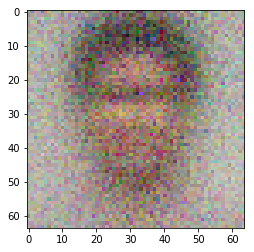

In [81]:
%matplotlib inline
import cv2
plt.imshow(cv2.cvtColor(res_samp[5].reshape(64,64,3), cv2.COLOR_BGR2RGB))
